<h1>Método de Gauss-Seidel com Python</h1>
<p>Este notebook apresenta a implementação do método iterativo de Gauss-Seidel para resolver sistemas de equações lineares da forma <b>Ax = b</b>.</p>
<p>O método de Gauss-Seidel é um processo iterativo que atualiza a solução aproximada a cada passo, utilizando os valores mais recentes já calculados na mesma iteração. Ele continua até que a solução convirja para um resultado dentro de uma tolerância de erro especificada.</p>
<p>É especialmente eficiente para matrizes que são <b>diagonalmente dominantes</b>.</p>

## 🧮 Sistema a ser resolvido proposto pelo professor

Vamos resolver o seguinte sistema:
\begin{cases}
3x_1 & - & 0,1x_2 & - & 0,2x_3 & = & 7,85 \\
0,1x_1 & + & 7x_2 & - & 0,3x_3 & = & -19,3 \\
0,3x_1 & - & 0,2x_2 & + & 10x_3 & = & 71,4 \\
\end{cases}


In [34]:
# Bloco de código 1: Importando as bibliotecas e definindo o sistema

import numpy as np
import matplotlib.pyplot as plt

M = np.array([
    [3.0, -0.1, -0.2,  7.85],
    [0.1,  7.0, -0.3, -19.3],
    [0.3, -0.2, 10.0,  71.4]
])

print("Matriz Aumentada do sistema [A|b]:")
print(M)

Matriz Aumentada do sistema [A|b]:
[[  3.    -0.1   -0.2    7.85]
 [  0.1    7.    -0.3  -19.3 ]
 [  0.3   -0.2   10.    71.4 ]]


#### Bloco 2: Definindo Parâmetros e Inicialização

<p>Nesta etapa, definimos os parâmetros de controle do método:</p>
<ul>
    <li><b>Número máximo de iterações (<code>nloop</code>):</b> Um limite para evitar loops infinitos caso o método não convirja.</li>
    <li><b>Tolerância (<code>erro</code>):</b> O critério de parada. Se a maior mudança em qualquer variável da solução for menor que este valor, consideramos que a solução convergiu.</li>
</ul>
<p>Também inicializamos as estruturas de dados necessárias, como a matriz para armazenar os resultados e uma lista para guardar o histórico de erros para visualização.</p>

In [35]:
# Bloco de código 2: Parâmetros e inicialização

# Parâmetros de controle
nloop = 50       # Número máximo de iterações permitidas
erro = 0.001     # Tolerância para o critério de parada

# Dimensões da matriz
m = M.shape[0]   # Número de equações (linhas)
n = M.shape[1]   # Número de colunas (coeficientes + termo independente)

# Matriz para armazenar as soluções. Usamos duas linhas para alternar entre a iteração anterior e a atual
R = np.zeros((2, m))

# Lista para armazenar o erro a cada iteração (para o gráfico)
erros_por_iteracao = []

# Índices para as linhas da matriz R
i1 = 0  # Índice da iteração anterior
i2 = 1  # Índice da iteração atual

# Variáveis de controle do loop
pare = False  # Flag que se torna True quando o critério de parada é atingido
k = 0         # Contador de iterações

#### Bloco 3: Função de Cálculo de uma Iteração

<p>A função abaixo implementa o núcleo do método. Ela executa uma única iteração de Gauss-Seidel, calculando os novos valores para cada variável <code>x_i</code> com base na fórmula:</p>
<pre>
x_i<sup>(k+1)</sup> = (1 / a<sub>ii</sub>) * [ b<sub>i</sub> - &sum;<sub>j=1</sub><sup>i-1</sup> (a<sub>ij</sub> * x<sub>j</sub><sup>(k+1)</sup>) - &sum;<sub>j=i+1</sub><sup>n</sup> (a<sub>ij</sub> * x<sub>j</sub><sup>(k)</sup>) ]
</pre>
<p>Note que para calcular <code>x_i</code> na nova iteração (k+1), usamos os valores de <code>x_j</code> (com j < i) que <b>já foram calculados nesta mesma iteração</b>. Isso acelera a convergência em comparação com o método de Jacobi.</p>

In [36]:
# Bloco de código 3: Função que realiza uma iteração

def gauss_seidel_iteracao(M, R, i1, i2):
    """
    Executa uma iteração do método de Gauss-Seidel.
    M: Matriz aumentada do sistema.
    R: Matriz de resultados.
    i1: Índice da linha da iteração anterior em R.
    i2: Índice da linha da iteração atual em R.
    """
    m = M.shape[0] # Número de equações
    n = M.shape[1] # Número de colunas
    
    # Itera sobre cada equação para encontrar o novo x_i
    for i in range(m):
        soma = 0.0
        # Itera sobre as colunas para calcular o somatório
        for j in range(m):
            if i != j:
                # Se j < i, o valor de x_j já foi atualizado nesta iteração.
                # Usamos o valor da linha i2 (iteração atual).
                if j < i:
                    soma += M[i, j] * R[i2, j]
                # Se j > i, o valor de x_j ainda não foi atualizado.
                # Usamos o valor da linha i1 (iteração anterior).
                else:
                    soma += M[i, j] * R[i1, j]
        
        # Calcula o novo valor de x_i e o armazena na linha da iteração atual
        R[i2, i] = (M[i, n-1] - soma) / M[i, i]
        
    return R

#### Bloco 4: Função para Verificar a Convergência

<p>Após cada iteração, precisamos verificar se o método já convergiu. Fazemos isso calculando o <b>erro absoluto máximo</b> entre a solução da iteração atual e a anterior.</p>
<pre>
Erro = max( |x<sub>i</sub><sup>(k+1)</sup> - x<sub>i</sub><sup>(k)</sup>| ) para todo i
</pre>
<p>Se esse erro for menor que a nossa tolerância, o loop principal para.</p>

In [37]:
# Bloco de código 4: Função para checar o critério de parada

def verifica_convergencia(R, i1, i2, erro_definido):
    """
    Calcula o erro máximo entre a iteração atual e a anterior.
    Retorna True se o erro for menor que a tolerância.
    """
    # Calcula a diferença absoluta entre os vetores de solução
    diferencas = np.abs(R[i2] - R[i1])
    
    # Encontra o maior valor nessa diferença
    erro_maximo = np.max(diferencas)
    
    # Compara com a tolerância
    convergiu = erro_maximo < erro_definido
    
    return convergiu, erro_maximo

#### Bloco 5: Loop Principal e Apresentação dos Resultados

<p>Este é o loop principal que orquestra todo o processo. A cada passo, ele:</p>
<ol>
    <li>Chama a função <code>gauss_seidel_iteracao</code> para calcular a nova aproximação.</li>
    <li>Chama a função <code>verifica_convergencia</code> para checar o critério de parada.</li>
    <li>Armazena o erro da iteração atual para o gráfico.</li>
    <li>Imprime o estado da solução e o erro atual.</li>
    <li>Atualiza os contadores e índices para a próxima iteração.</li>
</ol>
<p>O loop termina se a solução convergir ou se o número máximo de iterações for atingido.</p>

In [38]:
# Bloco de código 5: Loop principal de iteração

print("Iniciando o método de Gauss-Seidel...")
print("-" * 60)
print(f"{'Iteração':<10} | {'x1':>10} | {'x2':>10} | {'x3':>10} | {'Erro Máximo':>15}")
print("-" * 60)

while not pare and k < nloop:
    # 1. Realiza uma nova iteração
    R = gauss_seidel_iteracao(M, R, i1, i2)
    
    # 2. Verifica a convergência
    convergiu, tole = verifica_convergencia(R, i1, i2, erro)
    
    # 3. Armazena o erro para o gráfico
    erros_por_iteracao.append(tole)
    
    # 4. Imprime os resultados da iteração atual
    print(f"{k+1:<10} | {R[i2,0]:10.6f} | {R[i2,1]:10.6f} | {R[i2,2]:10.6f} | {tole:15.6f}")
    
    # 5. Verifica se deve parar
    if convergiu:
        pare = True
    else:
        # Prepara para a próxima iteração: a iteração atual (i2) se torna a anterior (i1)
        i1, i2 = i2, i1 
        k += 1

print("-" * 60)

# Mensagem final
if pare:
    print(f"\nConvergência alcançada na iteração {k+1} com erro < {erro}.")
    print("\nSolução aproximada:")
    # A solução final está na linha i2
    solucao_final = R[i2]
    print(f"x1 = {solucao_final[0]:.6f}")
    print(f"x2 = {solucao_final[1]:.6f}")
    print(f"x3 = {solucao_final[2]:.6f}")
else:
    print(f"\nO método não convergiu em {nloop} iterações.")
    solucao_final = R[i2]
    print("A última solução calculada foi:")
    print(f"x1 = {solucao_final[0]:.6f}, x2 = {solucao_final[1]:.6f}, x3 = {solucao_final[2]:.6f}")

Iniciando o método de Gauss-Seidel...
------------------------------------------------------------
Iteração   |         x1 |         x2 |         x3 |     Erro Máximo
------------------------------------------------------------
1          |   2.616667 |  -2.794524 |   7.005610 |        7.005610
2          |   2.990557 |  -2.499625 |   7.000291 |        0.373890
3          |   3.000032 |  -2.499988 |   6.999999 |        0.009475
4          |   3.000000 |  -2.500000 |   7.000000 |        0.000032
------------------------------------------------------------

Convergência alcançada na iteração 4 com erro < 0.001.

Solução aproximada:
x1 = 3.000000
x2 = -2.500000
x3 = 7.000000


#### Bloco 6: Visualização da Convergência

<p>Um gráfico do erro em função do número de iterações é uma forma poderosa de visualizar a convergência do método. Espera-se que o erro diminua exponencialmente a cada passo, até atingir um patamar abaixo da tolerância definida.</p>

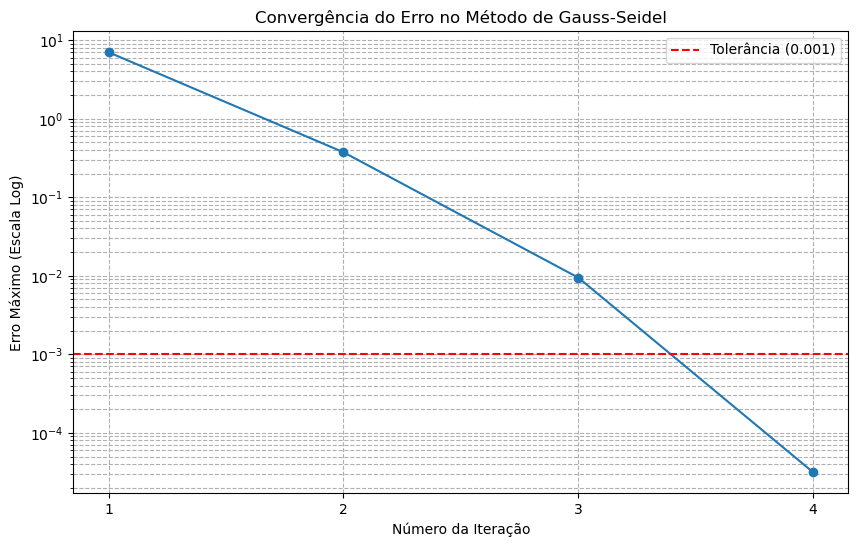

In [39]:
# Bloco de código 6: Gráfico de convergência do erro

if erros_por_iteracao:
    plt.figure(figsize=(10, 6))
    # Plota o erro em escala logarítmica para melhor visualização da queda
    plt.semilogy(range(1, len(erros_por_iteracao) + 1), erros_por_iteracao, marker='o', linestyle='-')
    plt.title('Convergência do Erro no Método de Gauss-Seidel')
    plt.xlabel('Número da Iteração')
    plt.ylabel('Erro Máximo (Escala Log)')
    plt.xticks(range(1, len(erros_por_iteracao) + 1))
    plt.grid(True, which="both", ls="--")
    # Linha horizontal para a tolerância
    plt.axhline(y=erro, color='r', linestyle='--', label=f'Tolerância ({erro})')
    plt.legend()
    plt.show()

#### Bloco 7: Conclusão

<p>O notebook demonstrou a implementação passo a passo do método de Gauss-Seidel e a sua visualização.</p>
<p>A solução encontrada foi <b>x &#x2248; [𝑥1 = 3, 𝑥2 = −2,5 e 𝑥3 = 7]</b>, que é a solução exata para este sistema. O método convergiu rapidamente, como pode ser confirmado tanto pela tabela de resultados quanto pelo gráfico de convergência.</p>
<p>Este exemplo ilustra o poder dos métodos iterativos para resolver sistemas lineares, que são fundamentais em diversas áreas da ciência e engenharia.</p>